# Dataset obtained from:

https://www.mammaldiversity.org/


# How to build the hierarchy or the knowledge graph?

## Extract only the major ranks from the dataset: (Common Name, species, genus, family, order, subclass)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/species.csv")

# columns to keep
keep = [
    "mainCommonName",
    "sciName",
    "genus",
    "family",
    "order",
    "subclass"
]

# rename columns
df_small = (
    df[keep]
      .drop_duplicates()
      .reset_index(drop=True)
      .rename(columns={
          "mainCommonName": "CommonName",
          "sciName": "Species",
          "genus": "Genus",
          "family": "Family",
          "order": "Order",
          "subclass": "Subclass",
      })
)

# save
df_small.to_csv("/content/mammal_major_ranks.csv", index=False)


In [ ]:
print(df_small)

                              CommonName                   Species  \
0                               Platypus  Ornithorhynchus_anatinus   
1                   Short-beaked Echidna    Tachyglossus_aculeatus   
2     Attenborough's Long-beaked Echidna   Zaglossus_attenboroughi   
3            Eastern Long-beaked Echidna         Zaglossus_bartoni   
4            Western Long-beaked Echidna        Zaglossus_bruijnii   
...                                  ...                       ...   
6796                  Pygmy Beaked Whale     Mesoplodon_peruvianus   
6797            Stejneger's Beaked Whale     Mesoplodon_stejnegeri   
6798                 Spade-toothed Whale      Mesoplodon_traversii   
6799             Shepherd's Beaked Whale      Tasmacetus_shepherdi   
6800               Cuvier's Beaked Whale       Ziphius_cavirostris   

                Genus             Family         Order    Subclass  
0     Ornithorhynchus  Ornithorhynchidae   Monotremata  Yinotheria  
1        Tachyglossus

In [ ]:
# number of unique Species
df_small["Species"].nunique()

6801

In [ ]:
# number of unique Genus
df_small["Genus"].nunique()

1357

In [ ]:
# number of unique Family
df_small["Family"].nunique()

167

In [ ]:
# number of unique Orders
df_small["Order"].nunique()

27

In [ ]:
# number of unique Subclasses
df_small["Subclass"].nunique()

2

In [ ]:
# Print unique Subclasses
counts = df_small["Subclass"].value_counts(dropna=False)
print(counts)

Subclass
Theria        6796
Yinotheria       5
Name: count, dtype: int64


## Generate Embeddings (OpenAI text-embedding-3-large) - (embed species + commonName)

In [ ]:
import os, numpy as np
from tqdm import tqdm
from openai import OpenAI

In [ ]:
client = OpenAI(api_key="")

def get_openai_embeddings(texts, model="text-embedding-3-large", batch_size=96):
    all_embeds = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i : i + batch_size]

        response = client.embeddings.create(
            model=model,
            input=batch,
            encoding_format="float"
        )

        batch_sorted = sorted(response.data, key=lambda o: o.index)
        all_embeds.extend([item.embedding for item in batch_sorted])

    return np.asarray(all_embeds, dtype=np.float32)


In [ ]:
# embed species + commonName
df_small["text_for_embed"] = (
    df_small["Species"].str.replace("_", " ")
    + " | "
    + df_small["CommonName"]
)

texts = df_small["text_for_embed"].tolist()
emb   = get_openai_embeddings(texts)

print(emb.shape, emb.dtype)

Embedding: 100%|██████████| 71/71 [05:32<00:00,  4.68s/it]


(6801, 3072) float32


#KMeans (K chosen = 55 from 0-500)
- since there are 1357 unique Genus

In [ ]:
pip install kneed

Applying PCA for dimensionality reduction...
Reduced dimensions from 3072 to 100
Explained variance ratio: 0.63


Elbow curve MiniBatchKMeans: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Elbow suggests k = 55


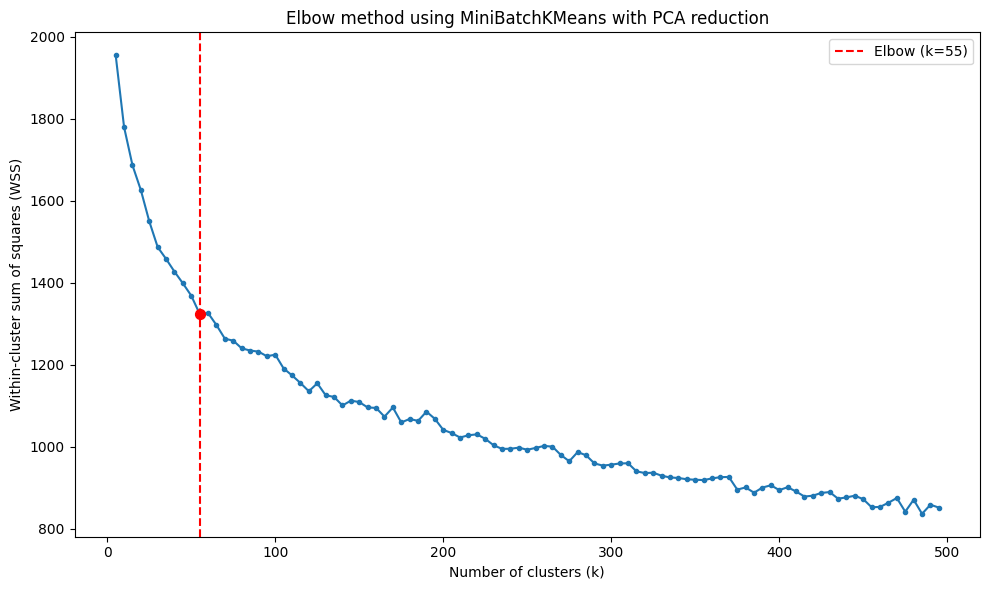

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from tqdm import tqdm

# Your embedding data is already stored in 'emb' variable
# First, convert to proper dtype
X = np.asarray(emb, dtype=np.float32)

# Step 1: Apply PCA to reduce dimensionality
# Reduce to 100 dimensions (you can adjust this number based on your needs)
print("Applying PCA for dimensionality reduction...")
n_components = 100  # Choose an appropriate number
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)
print(f"Reduced dimensions from {X.shape[1]} to {X_reduced.shape[1]}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")

# Step 2: Use MiniBatchKMeans with your range
k_values, wss_values = [], []
batch_size = 256  # Adjust based on your memory constraints

# Use your desired range of 1000-1500 with step 5
for k in tqdm(range(5, 500, 5), desc="Elbow curve MiniBatchKMeans"):
    # Use MiniBatchKMeans instead of regular KMeans
    mbkm = MiniBatchKMeans(
        n_clusters=k,
        batch_size=batch_size,
        random_state=42,
        max_iter=100,     # Limit max iterations
        n_init=3          # Reduce number of initializations
    )
    mbkm.fit(X_reduced)   # Use the PCA-reduced data
    k_values.append(k)
    wss_values.append(mbkm.inertia_)

# Elbow detection
kl = KneeLocator(k_values, wss_values, curve='convex', direction='decreasing')
optimal_k = kl.elbow
print(f"Elbow suggests k = {optimal_k}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', markersize=3)
if optimal_k is not None:
    plt.axvline(optimal_k, color='red', ls='--', label=f'Elbow (k={optimal_k})')
    plt.scatter(optimal_k,
                wss_values[k_values.index(optimal_k)],
                color='red', zorder=5, s=50)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster sum of squares (WSS)")
plt.title("Elbow method using MiniBatchKMeans with PCA reduction")
plt.legend()
plt.tight_layout()
plt.savefig('elbow_curve_minibatch.png')  # Save the figure
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

km_final  = KMeans(n_clusters=optimal_k, n_init=30, random_state=42)
labels    = km_final.fit_predict(emb)
centroids = km_final.cluster_centers_

# Method from [LLMEdgeRefine: Enhancing Text Clustering with LLM-Based Boundary Point Refinement](https://aclanthology.org/2024.emnlp-main.1025/)

## SPEC: "Super-point Enhanced Clustering"
1) **Extract the farthest α% (e.g., 10%) from each cluster:** For each cluster, compute Euclidean distance between all points and their cluster centroid. Select the top α% farthest points (these are considered edge points or potential outliers).

2) **Form a super-point from each set of edge points:** For each cluster, average the embeddings of the selected edge points to form a single super-point vector. This acts as a dense representation of the "tail" of the cluster and reduces the influence of noise.

3) **Treat remaining (non-edge) points as singleton clusters**: Each non-super-point stays individually represented. So the new dataset consists of:
- One super-point per cluster
- All remaining points as singletons

4) **Run agglomerative clustering on this mixed set:** Use AgglomerativeClustering(linkage="average", n_clusters=K) to cluster the combined set of singleton points and super-points. Fix cardinality.
- Super-points act like anchors to steer cluster shapes.

5) **Assign new labels to all original points**: Every original point (including those used to create super-points) is assigned a new cluster label based on its closest new cluster (e.g., via nearest centroid or label propagation).


6) **Recompute centroids for each cluster**: Update the cluster centroids based on the newly assigned labels. These centroids will be used in the next iteration (if repeating SPEC).

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def spec_step(X, labels, centroids, alpha=.10):
    N = X.shape[0]
    super_points, super_idx = [], []
    remain_idx = []

    # 1) build super-points per cluster
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        # centroid of farthest points: super point
        super_points.append(X[far_idx].mean(0))
        super_idx.extend(far_idx)
        remain_idx.extend(np.setdiff1d(idx, far_idx))

    # 2) make the dataset for agglomerative clustering
    X_new   = np.vstack([X[remain_idx], np.vstack(super_points)])
    #   first remain_idx rows are singletons, rest are super points
    n_clusters = len(set(labels))
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    new_labels = ac.fit_predict(X_new)

    # 3) map back to original order
    final = np.empty(N, dtype=int)

    # a) singletons
    final[remain_idx] = new_labels[:len(remain_idx)]

    # b) far points look up by cluster
    offset = len(remain_idx)
    for j, c in enumerate(np.unique(labels)):
        lab_for_super = new_labels[offset + j]
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        final[far_idx] = lab_for_super


    # 4) recompute centroids
    cents = np.vstack([X[final == k].mean(0) for k in range(n_clusters)])
    return final, cents


In [ ]:
for _ in range(5):
    labels, centroids = spec_step(emb, labels, centroids, alpha=.10)


## LACR (LLM-Assisted Cluster Refinement) Using GPT-4.1:
1) For each cluster, extract the farthest β% (10%) of points from the centroid (based on Euclidean distance). These are considered edge points likely to be noisy or semantically misplaced.

2) For the farthest points, rank all centroids by cosine similarity and pick the top 8 closest clusters. Candidate descriptions for each cluster contains "Species: X, Common Name: Y" for Max 20 animals closest to the center of the cluster

3) Query LLM if each of the farthest points should stay in that cluster or reassigned to one of the top 8 closest clusters. If LLM outputs outputs "keep", label is unchanged. If LLM outputs a number, reassign to that cluster.

4) Recompute centroids based on updated labels

In [ ]:
from openai import OpenAI
import numpy as np

client = OpenAI(api_key="")

# return True if LLM says 'keep', False if 'move'.
def llm_keep(label_to_desc, point_text, prompt_tmpl):
  prompt = prompt_tmpl.format(point=point_text, **label_to_desc)

  resp = client.chat.completions.create(
      model="gpt-4.1",
      messages=[{"role": "user", "content": prompt}],
      temperature=0
  )
  reply = resp.choices[0].message.content.strip().upper()

  if reply == "KEEP":
      return True

  try:
      return int(reply)
  except ValueError:
      return True


prompt_template = """
You are refining clusters of animal names.
{point}

Below are 8 candidate cluster descriptions:

1. {c1}
2. {c2}
3. {c3}
4. {c4}
5. {c5}
6. {c6}
7. {c7}
8. {c8}

Choose the ONE cluster index that fits best, or say KEEP if it already fits.
Respond with just the number 1-8, or 'KEEP'.
"""
beta = 0.10
l = 3

for _ in range(l):
    move_these = []  # Fresh start every loop

    # 1) pick 10% farthest names per cluster
    unique_labels = np.unique(labels)

    # Create centroids for each unique label
    centroids = np.vstack([emb[labels == k].mean(0) for k in unique_labels])

    # Map labels to their index in centroids array
    label_to_centroid_idx = {label: i for i, label in enumerate(unique_labels)}

    # Map centroid indices back to original labels
    # This is the key fix - we need to know which original label each centroid corresponds to
    centroid_idx_to_label = {i: label for i, label in enumerate(unique_labels)}

    for k in unique_labels:
        idx = np.where(labels == k)[0]
        d = np.linalg.norm(emb[idx] - centroids[label_to_centroid_idx[k]], axis=1)
        take = min(len(idx), int(max(1, np.ceil(beta * len(idx)))))
        move_these.extend(idx[np.argsort(d)[-take:]])

    # 2) for every candidate point, build 8-nearest cluster list
    for idx in move_these:
        # cosine similarity to each centroid
        sims = (emb[idx] @ centroids.T) / (
            np.linalg.norm(emb[idx]) * np.linalg.norm(centroids, axis=1)
        )
        # Get indices of top 8 most similar centroids
        top8_centroid_indices = sims.argsort()[-8:][::-1]

        # Convert centroid indices to their corresponding cluster labels
        top8_labels = [centroid_idx_to_label[i] for i in top8_centroid_indices]

        # cluster description: max 50 animals per cluster, with Species + CommonName
        desc = {}
        for i, label in enumerate(top8_labels):
            cluster_idx = np.where(labels == label)[0]

            # Compute distance to centroid
            centroid_idx = label_to_centroid_idx[label]  # Get the correct centroid index
            dists = np.linalg.norm(emb[cluster_idx] - centroids[centroid_idx], axis=1)

            # Take 20 closest
            closest_idx = cluster_idx[np.argsort(dists)[:20]]

            subset = df_small.iloc[closest_idx][["Species", "CommonName"]]

            names = [f"Species: {row['Species']}, Common Name: {row['CommonName']}"
                     for _, row in subset.iterrows()]
            desc[f"c{i+1}"] = "\n".join(names)

        keep = llm_keep(desc, df_small.loc[idx, "text_for_embed"], prompt_template)
        if keep != True:
            # Convert selected index back to the actual label
            new_label = top8_labels[int(keep) - 1]
            labels[idx] = new_label

    # 3) after moves, recompute centroids
    # We need to regenerate these mappings with possibly new unique labels
    unique_labels = np.unique(labels)
    centroids = np.vstack([emb[labels == k].mean(0) for k in unique_labels])
    label_to_centroid_idx = {label: i for i, label in enumerate(unique_labels)}
    centroid_idx_to_label = {i: label for i, label in enumerate(unique_labels)}

# Evaluate and Inspect

In [ ]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(emb, labels)
print(f"Silhouette = {sil:.3f}")

df_small["cluster"] = labels


Silhouette = 0.067


### Print Common Name, Order, Family per each cluster

In [ ]:
# Make sure rows inside a cluster are ordered predictably
tmp = df_small.sort_values(["cluster", "Species"])

# How many examples per cluster?
n = 5

for c in sorted(tmp["cluster"].unique()):      # 0, 1, 2, …
    print(f"\n— Cluster {c} —")                # header line
    block = tmp[tmp["cluster"] == c].head(n)   # first n rows of this cluster
    print(block[["CommonName", "Order", "Family"]])    # choose columns to display


— Cluster 0 —
                   CommonName     Order      Family
2062     Armenian Birch Mouse  Rodentia  Sminthidae
2063     Northern Birch Mouse  Rodentia  Sminthidae
2064    Caucasian Birch Mouse  Rodentia  Sminthidae
2065  Long-tailed Birch Mouse  Rodentia  Sminthidae
2066   Tsimlyansk Birch Mouse  Rodentia  Sminthidae

— Cluster 1 —
               CommonName       Order            Family
5769   Allen's Yellow Bat  Chiroptera  Vespertilionidae
5770   Slender Yellow Bat  Chiroptera  Vespertilionidae
5862  Southern Yellow Bat  Chiroptera  Vespertilionidae
5865     Cuban Yellow Bat  Chiroptera  Vespertilionidae
5866  Northern Yellow Bat  Chiroptera  Vespertilionidae

— Cluster 2 —
                           CommonName         Order          Family
4588                  Cuban Solenodon  Eulipotyphla  Solenodontidae
1516                 Torre's Cave Rat      Rodentia      Echimyidae
449   Northern Maned Three-toed Sloth        Pilosa    Bradypodidae
2528              Gray-bellied Bruc

# Orders

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


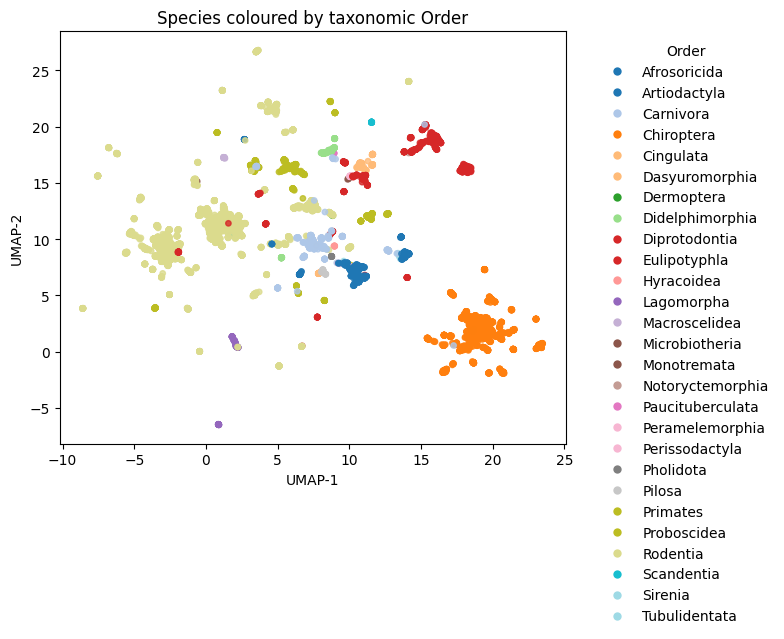

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines

# Compute UMAP embeddings (assuming 'embeddings' is your high-dimensional data)
reducer = umap.UMAP(random_state=42)
u = reducer.fit_transform(emb)  # define embeddings accordingly

orders = df_small["Order"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Order")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


## Print unique orders per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique orders per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Order"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Rodentia: 19

— Cluster 1 —
Chiroptera: 75

— Cluster 2 —
Rodentia: 129
Cingulata: 25
Eulipotyphla: 14
Pilosa: 12
Artiodactyla: 7
Carnivora: 6
Microbiotheria: 2
Perissodactyla: 1
Sirenia: 1

— Cluster 3 —
Eulipotyphla: 229

— Cluster 4 —
Didelphimorphia: 126
Paucituberculata: 7
Diprotodontia: 2

— Cluster 5 —
Rodentia: 82

— Cluster 6 —
Chiroptera: 87

— Cluster 7 —
Rodentia: 231

— Cluster 8 —
Rodentia: 109

— Cluster 9 —
Artiodactyla: 139
Perissodactyla: 11
Proboscidea: 1

— Cluster 10 —
Carnivora: 197
Rodentia: 3
Chiroptera: 2
Dasyuromorphia: 1

— Cluster 11 —
Rodentia: 64

— Cluster 12 —
Primates: 35

— Cluster 13 —
Rodentia: 125

— Cluster 14 —
Artiodactyla: 102
Carnivora: 34
Sirenia: 3

— Cluster 15 —
Chiroptera: 118

— Cluster 16 —
Dasyuromorphia: 89
Diprotodontia: 75
Peramelemorphia: 30
Monotremata: 5

— Cluster 17 —
Chiroptera: 69

— Cluster 18 —
Rodentia: 166

— Cluster 19 —
Rodentia: 86
Eulipotyphla: 18
Peramelemorphia: 1

— Cluster 20 —
Rodentia: 154
Primates

# Calculate Mean Cluster Purity by Order

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, orders):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        ords    = orders.iloc[idx]
        top     = ords.value_counts().iloc[0]
        purities.append(top / len(ords))
    return np.mean(purities)

orders = df_small["Order"]
print("Mean cluster purity by Order:", mean_purity_from_labels(labels, orders))


Mean cluster purity by Family: 0.9280933018073181


# Families

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-38-d6475e3022bb>:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


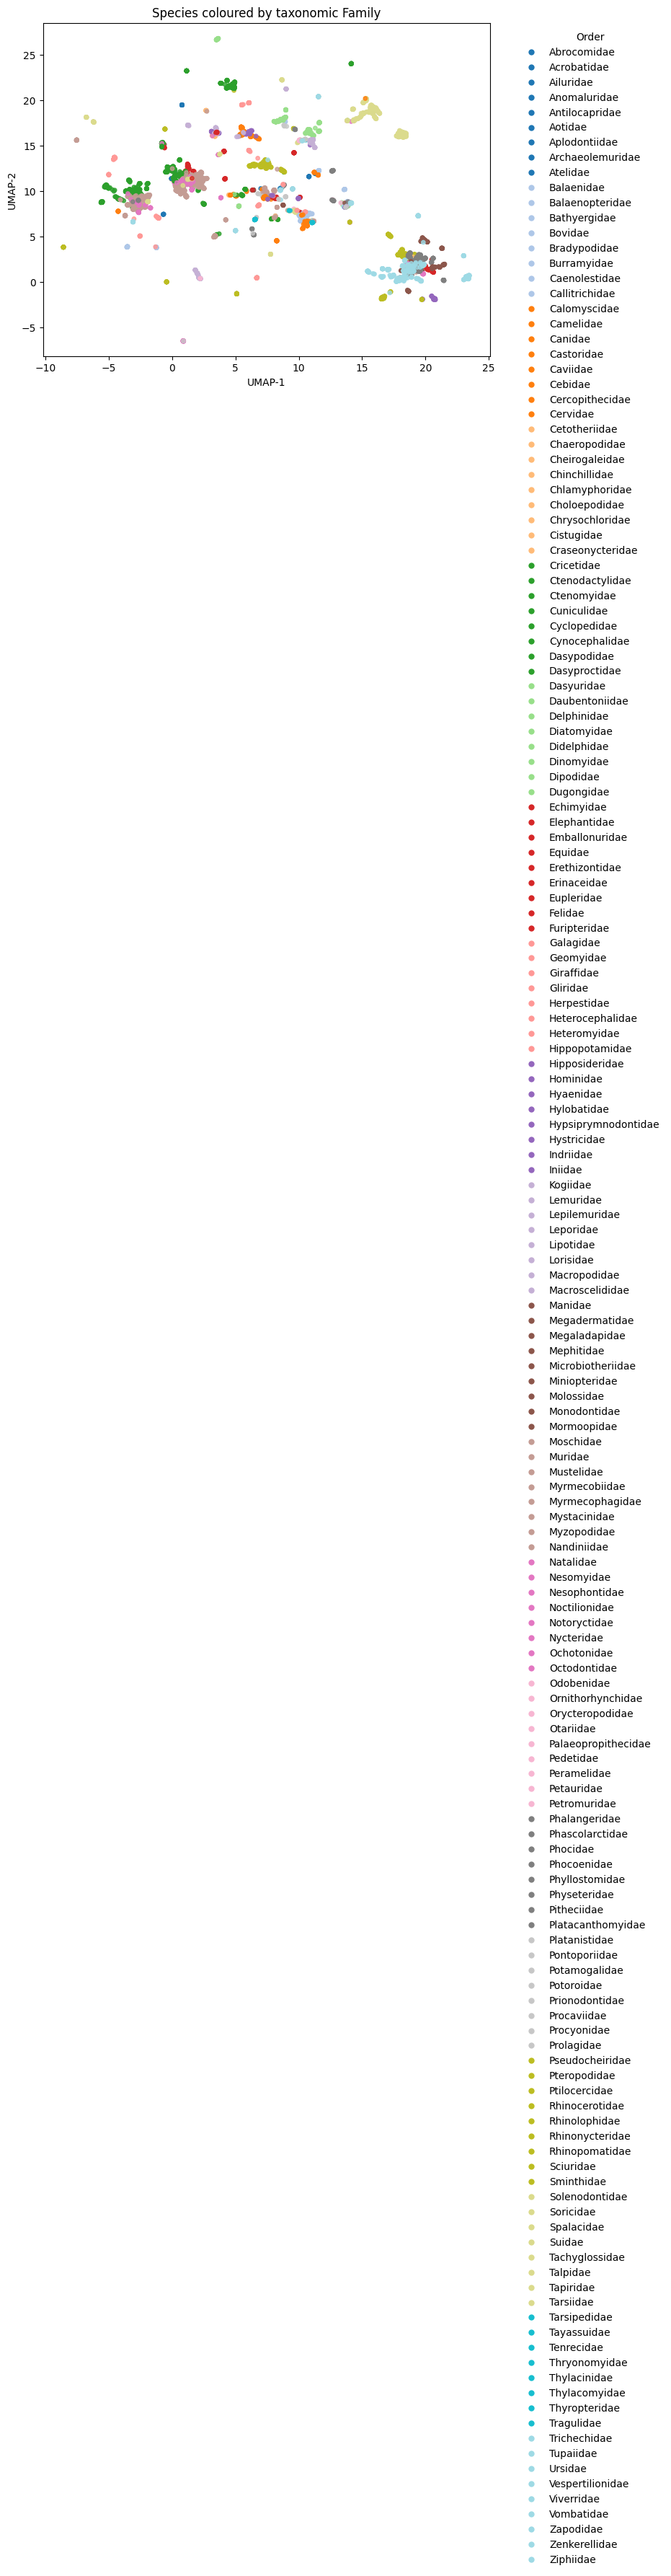

In [ ]:

# Compute UMAP embeddings (assuming 'embeddings' is your high-dimensional data)
reducer = umap.UMAP(random_state=42)
u = reducer.fit_transform(emb)  # define embeddings accordingly

orders = df_small["Family"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Family")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


# Print unique Families per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique families per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Family"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Sminthidae: 19

— Cluster 1 —
Vespertilionidae: 39
Phyllostomidae: 34
Megadermatidae: 1
Emballonuridae: 1

— Cluster 2 —
Cricetidae: 37
Echimyidae: 33
Caviidae: 24
Dasyproctidae: 15
Chlamyphoridae: 14
Dasypodidae: 11
Nesophontidae: 8
Chinchillidae: 8
Octodontidae: 7
Cyclopedidae: 6
Procyonidae: 4
Solenodontidae: 4
Myrmecophagidae: 3
Tayassuidae: 3
Camelidae: 3
Cuniculidae: 2
Choloepodidae: 2
Mephitidae: 2
Microbiotheriidae: 2
Bradypodidae: 1
Sciuridae: 1
Talpidae: 1
Dinomyidae: 1
Erinaceidae: 1
Petromuridae: 1
Cervidae: 1
Tapiridae: 1
Trichechidae: 1

— Cluster 3 —
Soricidae: 229

— Cluster 4 —
Didelphidae: 126
Caenolestidae: 7
Petauridae: 2

— Cluster 5 —
Echimyidae: 68
Cricetidae: 7
Nesomyidae: 2
Abrocomidae: 2
Muridae: 2
Octodontidae: 1

— Cluster 6 —
Hipposideridae: 86
Emballonuridae: 1

— Cluster 7 —
Cricetidae: 214
Echimyidae: 5
Abrocomidae: 4
Octodontidae: 4
Muridae: 2
Nesomyidae: 1
Spalacidae: 1

— Cluster 8 —
Muridae: 97
Nesomyidae: 12

— Cluster 9 —
Cervidae: 5

# Calculate Mean Cluster Purity by Family

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, families):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        fams    = families.iloc[idx]
        top     = fams.value_counts().iloc[0]
        purities.append(top / len(fams))
    return np.mean(purities)

families = df_small["Family"]
print("Mean cluster purity by Family:", mean_purity_from_labels(labels, families))


Mean cluster purity by Family: 0.750021820954869


# Genus

# Print unique Genus per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique families per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Genus"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Sicista: 19

— Cluster 1 —
Sturnira: 25
Scotophilus: 20
Rhogeessa: 12
Vampyressa: 6
Lasiurus: 4
Vampyriscus: 3
Baeodon: 2
Scotoecus: 1
Lavia: 1
Saccolaimus: 1

— Cluster 2 —
Oxymycterus: 18
Dasyprocta: 13
Dasypus: 11
Nesophontes: 8
Cavia: 7
Necromys: 6
Microcavia: 6
Cyclopes: 6
Geocapromys: 5
Cabassous: 5
Thrichomys: 5
Mesocapromys: 5
Octodon: 5
Galea: 5
Lagidium: 5
Graomys: 4
Brucepattersonius: 4
Nasua: 3
Lama: 3
Solenodon: 3
Capromys: 3
Toromys: 3
Plagiodontia: 3
Reithrodon: 3
Myoprocta: 2
Tolypeutes: 2
Tamandua: 2
Isolobodon: 2
Dromiciops: 2
Kerodon: 2
Hydrochoerus: 2
Cuniculus: 2
Dolichotis: 2
Conepatus: 2
Choloepus: 2
Chaetophractus: 2
Chinchilla: 2
Boromys: 1
Bradypus: 1
Atopogale: 1
Geoxus: 1
Lagostomus: 1
Hyperplagiodontia: 1
Hexolobodon: 1
Dinomys: 1
Chlamyphorus: 1
Chelemys: 1
Dicotyles: 1
Calyptophractus: 1
Euryzygomatomys: 1
Euphractus: 1
Galemys: 1
Mysateles: 1
Petromus: 1
Parachoerus: 1
Otohylomys: 1
Octodontomys: 1
Myocastor: 1
Marmota: 1
Myrmecophaga: 1
P

# Calculate Mean Cluster Purity by Genus

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, genuses):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        gens    = genuses.iloc[idx]
        top     = gens.value_counts().iloc[0]
        purities.append(top / len(gens))
    return np.mean(purities)

genuses = df_small["Genus"]
print("Mean cluster purity by Genus:", mean_purity_from_labels(labels, genuses))

Mean cluster purity by Genus: 0.3832641429409337


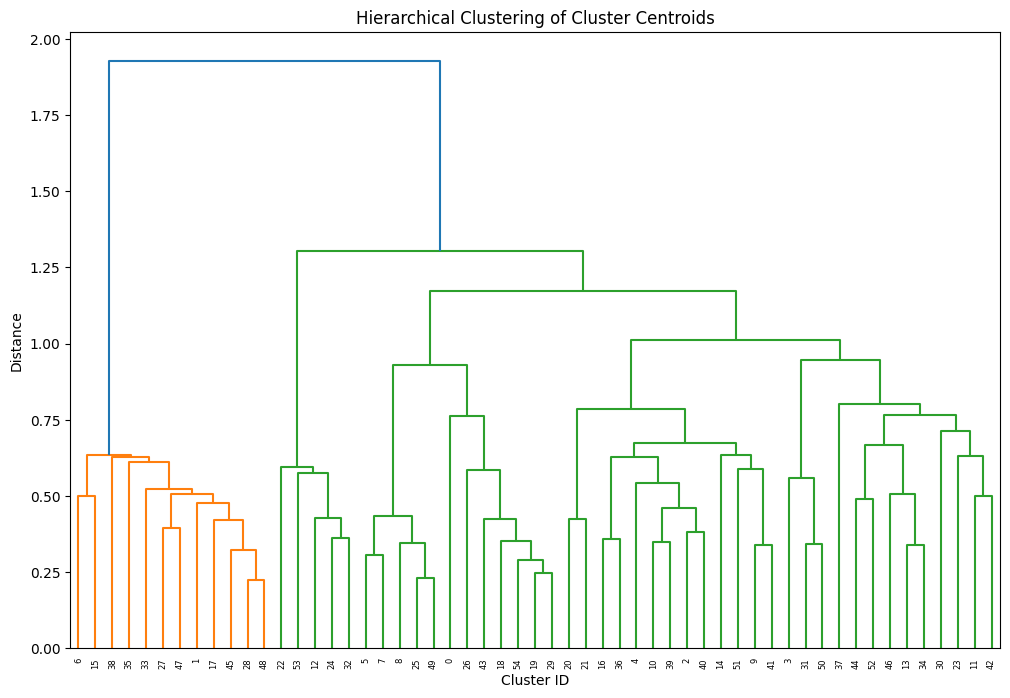

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Get centroids of your current clusters
cluster_centroids = np.array([emb[labels == i].mean(axis=0) for i in np.unique(labels)])

# Perform hierarchical clustering on centroids
Z = linkage(cluster_centroids, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering of Cluster Centroids')
plt.xlabel('Cluster ID')
plt.ylabel('Distance')
plt.show()